# Generate GAN Images

This notebook demonstrates how to generate images using a pretrained GAN model from torch.hub.

In [1]:
import torch
import torchvision
from torchvision.utils import save_image
import os
import matplotlib.pyplot as plt
%matplotlib inline

## Configuration and Utilities

In [2]:
# Monkeypatch torch.optim.Adam to clean up betas argument
# effectively fixing the "betas must be either both floats or both Tensors" error
# caused by pytorch_GAN_zoo passing [0, 0.99] as betas.
original_adam_init = torch.optim.Adam.__init__

def patched_adam_init(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                      weight_decay=0, amsgrad=False, *, maximize=False,
                      capturable=False, differentiable=False,
                      foreach=None):
    if isinstance(betas, list):
        betas = tuple(float(x) for x in betas)
    original_adam_init(self, params, lr=lr, betas=betas, eps=eps,
                       weight_decay=weight_decay, amsgrad=amsgrad,
                       maximize=maximize, capturable=capturable,
                       differentiable=differentiable, foreach=foreach)

torch.optim.Adam.__init__ = patched_adam_init

output_dir = 'gan_generated_images'
os.makedirs(output_dir, exist_ok=True)

## Load Model

Loading the pretrained PGAN model from `facebookresearch/pytorch_GAN_zoo`.

In [3]:
model_name = 'PGAN'
num_images = 4

print(f"Loading {model_name} model from facebookresearch/pytorch_GAN_zoo...")

try:
    use_gpu = torch.cuda.is_available()
    # Loading the model. Using 'test' to get a pre-trained model for inference.
    model = torch.hub.load('facebookresearch/pytorch_GAN_zoo:hub', model_name, model_name='celebAHQ-512', pretrained=True, useGPU=use_gpu)
    print("Model loaded successfully.")
except Exception:
    import traceback
    traceback.print_exc()

Loading PGAN model from facebookresearch/pytorch_GAN_zoo...


Using cache found in /Users/arishp/.cache/torch/hub/facebookresearch_pytorch_GAN_zoo_hub


Average network found !
Model loaded successfully.


## Generate Images

In [4]:
# Generate random noise vectors
# PGAN for celebAHQ-512 expects input noise of dimension (num_images, 512)
noise_dim = 512
noise, _ = model.buildNoiseData(num_images)

print("Generating images...")
with torch.no_grad():
    generated_images = model.test(noise)
print('Generated images shape:', generated_images.shape)

Generating images...
Generated images shape: torch.Size([4, 3, 512, 512])


## Save and Display Images

Saved gan_generated_images/generated_image_1.png
Saved gan_generated_images/generated_image_2.png
Saved gan_generated_images/generated_image_3.png
Saved gan_generated_images/generated_image_4.png


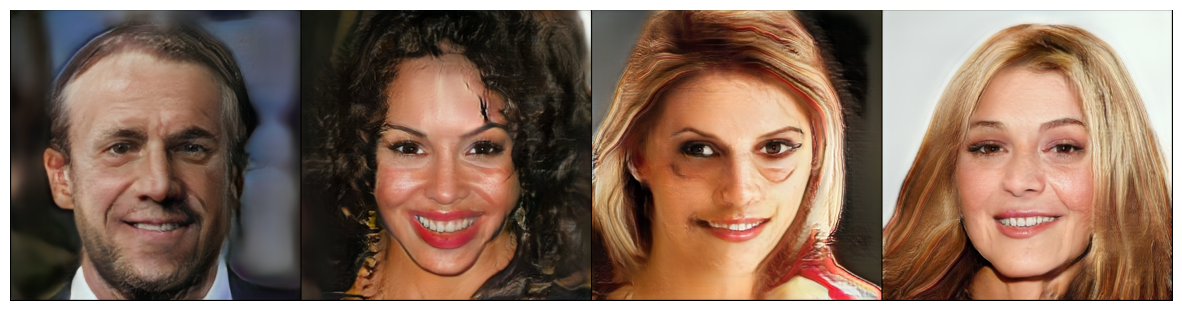

In [5]:
def show_images(images):
    grid_img = torchvision.utils.make_grid(images, nrow=4, normalize=True, value_range=(-1, 1))
    plt.figure(figsize=(15, 15))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

# Save images
for i, img in enumerate(generated_images):
    file_path = os.path.join(output_dir, f'generated_image_{i+1}.png')
    save_image(img, file_path, normalize=True, value_range=(-1, 1))
    print(f"Saved {file_path}")

# Display images within the notebook
show_images(generated_images)